In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer

from pymystem3 import Mystem
from string import punctuation
import nltk
nltk.download("stopwords")
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk import word_tokenize 
from nltk.util import ngrams

!pip install swifter
import swifter
from tqdm import tqdm

import numpy as np
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 5.2 MB/s 
     |████████████████████████████████| 281 kB 37.3 MB/s 
     |████████████████████████████████| 140 kB 41.5 MB/s 
  Created wheel for swifter: filename=swifter-1.1.3-py3-none-any.whl size=13078 sha256=72ad5021461fb73281c412ad36ef34e2b1f1bc02015f10b3c349d7a600e162bd
  Stored in directory: /root/.cache/pip/wheels/e8/1a/1b/46aa7b0fac16d3ce1bccaac14bfe4fad972642217ae78d8160
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
df = pd.read_csv('join4.csv', sep =';', parse_dates=['workStartDate'], decimal=',')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8323 entries, 0 to 8322
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              8323 non-null   int64         
 1   Unnamed: 0.1            8323 non-null   int64         
 2   Unnamed: 0.1.1          8323 non-null   int64         
 3   clientId                8323 non-null   object        
 4   workUnit                8323 non-null   object        
 5   workUnitPrice           8323 non-null   float64       
 6   workStartDate           8323 non-null   datetime64[ns]
 7   latitude                8323 non-null   float64       
 8   longitude               8323 non-null   float64       
 9   name                    8323 non-null   object        
 10  description             8323 non-null   object        
 11  address                 8323 non-null   object        
 12  specialityId            8323 non-null   object  

In [ ]:
df['year'] = df['workStartDate'].dt.year
df['month'] = df['workStartDate'].dt.month

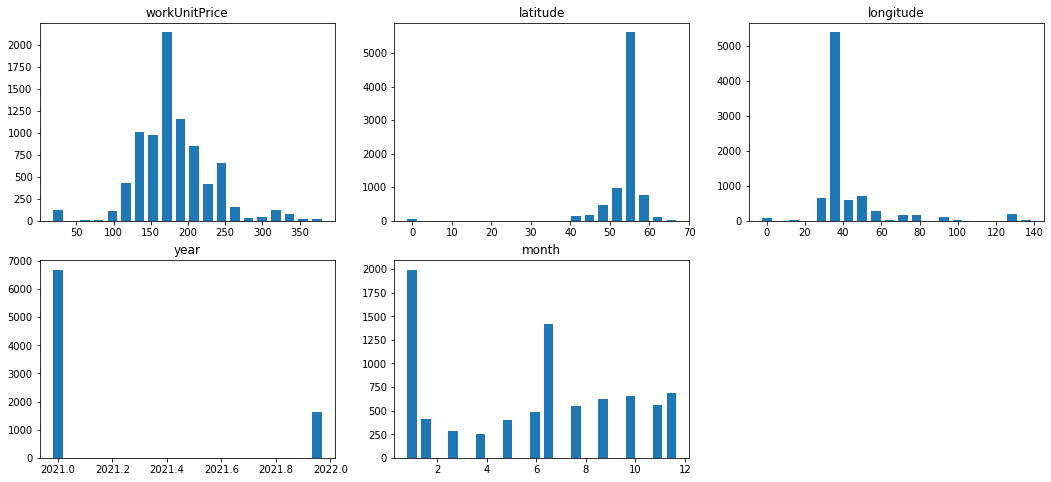

In [ ]:
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

visualize_distributions({
    'workUnitPrice': df['workUnitPrice'].dropna(),
    'latitude': df['latitude'].dropna(),
    'longitude': df['longitude'].dropna(),
    'year': df['year'].dropna(),
    'month': df['month'].dropna()
})

In [ ]:
import numpy as np
from scipy import stats

In [ ]:
stats.shapiro(df['workUnitPrice'])

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.935174286365509, 0.0)

In [ ]:
stats.kstest(df['workUnitPrice'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [ ]:
p=stats.kstest(df['workUnitPrice'], 'norm')
p1=p[1]

In [ ]:
p2=stats.kstest((df['workUnitPrice'] - np.mean(df['workUnitPrice'])) / np.std(df['workUnitPrice']), 'norm')
p=p2[1]

In [ ]:
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Sample does not look Gaussian (reject H0)


In [ ]:
import statsmodels.api as sm
sm.stats.normal_ad(df['workUnitPrice'])

(143.47225522320332, 0.0)

In [ ]:
df['workUnitPrice'].min()
#df['workUnitPrice'].max()

25.0

In [ ]:
!pip install pymorphy2
import pymorphy2
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import time

russian_stopwords = stopwords.words("russian")
lemma = pymorphy2.MorphAnalyzer()

#Код функции обработки текста:
def preprocess_text(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in russian_stopwords])
    punc_free = ''.join(ch for ch in stop_free if ch not in punctuation)
    text = " ".join([lemma.parse(word)[0].normal_form for word in punc_free.split(' ')])
    return text

df['lemmatized_description'] = df['description'].swifter.apply(preprocess_text)
df.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 8.2 MB 11.4 MB/s 


Pandas Apply:   0%|          | 0/8323 [00:00<?, ?it/s]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,clientId,workUnit,workUnitPrice,workStartDate,latitude,longitude,name,...,mean_sal082021,mean_sal092021,mean_sal102021,mean_sal112021,mean_sal122021,mean_sal012022,mrot_2021,mrot_2022,pm_2021,pm_2022
0,0,0,0,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.816065,37.458660,инженер-строительством,...,98974,102233,103393,104877,172553,103124,20361,21371,18029,18714
1,1,1,1,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.765458,37.796517,Электрик,...,98974,102233,103393,104877,172553,103124,20361,21371,18029,18714
2,2,2,2,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.685041,37.350683,Укладка пеноблоки с послойной (999) 890-55-38,...,98974,102233,103393,104877,172553,103124,20361,21371,18029,18714
3,3,3,3,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.816065,37.458660,Руководил бригадой строителей,...,98974,102233,103393,104877,172553,103124,20361,21371,18029,18714
4,4,4,4,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.685041,37.350683,Геодезист,...,98974,102233,103393,104877,172553,103124,20361,21371,18029,18714


In [ ]:
#df.to_csv('without_last_two_weeks.csv')

In [ ]:
russian_stopwords = stopwords.words("russian")

vectorizer = TfidfVectorizer(stop_words=russian_stopwords, token_pattern=u'(?ui)\\b\\w*[а-я]+\\w*\\b', ngram_range=(2,2))
matrix_tfidf = vectorizer.fit_transform(df['lemmatized_description'])

In [ ]:
top_words = pd.DataFrame(columns=df['specialityId'].unique())

def get_top_for_group(descriptions: pd.Series, group: str):
    global top_words
    if len(descriptions)<2 and len(descriptions.iloc[0].split())<2:
        return
    matrix_tfidf = vectorizer.fit_transform(descriptions)
    feature_array = np.array(vectorizer.get_feature_names())
    tfidf_sorting = np.argsort(matrix_tfidf.toarray()).flatten()[::-1]

    n = 10
    top_n = feature_array[tfidf_sorting][:n]
    top_words[group] = pd.Series(top_n)

In [ ]:
for group in top_words.keys():
    descriptions = df[df['specialityId']==group]['lemmatized_description']
    get_top_for_group(descriptions, group)

top_words

,af02837b-7814-43d0-97ab-48b2b9813120,6c183c81-cdb8-4d9c-a48f-877a516a93bc,256464cf-39f5-405c-a006-6b1505f6a961,7ce33ae6-7b86-48e8-9698-7650b3cbe42e,889bf632-b7e6-4c9e-887d-fa06acc47f10,4f1a1b97-21c8-4f64-badf-ab4760eebaed,623c4e3e-5971-43f7-895a-c9e68abf9ede,122997d2-780f-4103-ac0a-4178dd479934,d55e4589-beac-4964-bd69-d7efff11290c,708435b6-3756-4edd-91a8-6275c55a5199,...,02aa72e5-25f4-4431-b9ae-c0e884b9eec3,b702d1bc-3bb8-4ef3-9cec-c5497bdd3c1b,7d225fcd-e2f4-4d4f-9b32-ccfe41d00338,2781a00b-692a-4e31-aee4-e38f40ba1204,0c0e3d17-3d22-458b-aad0-e6a578c091f8,fed91815-58de-49a1-ae0b-2f5deb32a6f3,643112d9-7adc-4017-87b4-f2c99c4c4ee4,2968c6b3-07f2-4f0c-b314-eabaf536d94d,2ce10ad8-3312-4c09-98ff-446824a9db8b,fbdb0f85-1254-4820-b656-09ec907d91ff
0,требование нормативный,электротехнический работа,цементный молоко,торговый зал,точный соответствие,товар торговый,товар мерчандайзинг,электронный площадка,товар предпродажный,товар мерчандайзинг,...,сборка букет,обработка заказ,центр дневный,час наш,система видеонаблюдение,яндекс тд,торговый зал,электроинструмент строительный,февраль время,NaN
1,соответствие выполнять,организация проведение,пеноблок механизировать,работник торговый,соответствие проект,торговый зал,подготовка товар,функционал электронный,предпродажный подготовка,подготовка товар,...,заказ день,заказ день,торговый центр,звонок час,работа система,нуля обеспечение,выкладка торговый,строительный работа,требование размер,NaN
2,работа требование,выполнение электротехнический,доставляться техника,управление бригада,работа обеспечивать,выкладка товар,товар предпродажный,услуга направить,товар мерчандайзинг,предпродажный подготовка,...,букет заказ,выкладка товар,проверка qrкод,наш сотрудник,накладный контроль,маркетплейс формирование,торговый зал,работа работа,размер нога,NaN
3,работа подрядный,выполнить работа,захватка ручной,товар прилавок,проект геометрический,этикетка скомпановать,предпродажный подготовка,поручение заказчик,подготовка товар,товар предпродажный,...,сборка букет,обработка заказ,дневный график,сотрудник обрабатывать,контроль накладный,маркетплейс яндекс,выкладка торговый,работа электроинструмент,примерка отбор,NaN
4,проектный документация,исполнительный документация,каждый смотреть,выкладка товар,обеспечивать точный,мир фототчёт,выкладка товар,оказать комплекс,выкладка товар,выкладка товар,...,заказ день,заказ день,qrкод торговый,обрабатывать звонок,контроль выходавход,маркировка контроль,NaN,слесарный работа,приглашать девушка,NaN
5,подрядный организация,контроль выполнение,куб оплата,бригада человек,комплекс геодезический,навешивание вещь,эп порядок,обязываться поручение,кассир постоянка,поддержание порядок,...,букет заказ,выкладка товар,центр дневный,рубль звонок,выходавход работа,наименование описание,NaN,технический осмотр,отбор февраль,NaN
6,организация контроль,объект контроль,м3 объём,торговый зал,геометрический параметр,наведение порядок,покупатель выставление,направить консультирование,кондитерский продукция,зал выкладка,...,сборка букет,обработка заказ,торговый центр,ь курировать,торговый зал,наполнение карточка,NaN,прибор запорный,отбор обувной,NaN
7,объём качество,организация выполнение,месяц старт,работник торговый,геодезический работа,мытьё полка,подсорт товар,консультирование клиент,набчелны ул,магазин модис,...,заказ день,заказ день,проверка qrкод,поддержка ь,охрана торговый,необходимый склад,NaN,арматура тд,обязательный требование,NaN
8,нормативный проектный,оформление технический,механизировать способ,управление бригада,выполнение комплекс,мытьё оборудование,поддержание порядок,комплекс услуга,молочный товар,мерчендайзинг поддержание,...,букет заказ,выкладка товар,дневный график,звонок загрузка,система видеонаблюдение,новый площадка,NaN,вентиляция пожаротушение,обувной коллекция,NaN
9,контроль соответствие,учёт выполнить,мм стоимость,товар прилавок,точный соответствие,мужчина постоянка,подготовкаработа тсд,клиент заказчик,молочный отдел,модис предпродажный,...,сборка букет,выкладка товар,qrкод торговы

In [ ]:
def count_words_from_top(description, top_words):
    tokens = nltk.word_tokenize(description)
    bigram = list(ngrams(tokens, 2)) 
    count = 0
    for token in bigram:
        if ' '.join(token) in list(top_words):
            count += 1
    return count

for speciality in df['specialityId'].unique():
    df[speciality] = df['lemmatized_description'].apply(count_words_from_top, args=(top_words[speciality],))

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8323 entries, 0 to 8322
Data columns (total 75 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            8323 non-null   int64         
 1   Unnamed: 0.1                          8323 non-null   int64         
 2   Unnamed: 0.1.1                        8323 non-null   int64         
 3   clientId                              8323 non-null   object        
 4   workUnit                              8323 non-null   object        
 5   workUnitPrice                         8323 non-null   float64       
 6   workStartDate                         8323 non-null   datetime64[ns]
 7   latitude                              8323 non-null   float64       
 8   longitude                             8323 non-null   float64       
 9   name                                  8323 non-null   object        
 10  

In [ ]:
columns1 = ['mean_sal042021ho', 'mean_sal052021ho', 'mean_sal062021ho', 'mean_sal072021ho', 'mean_sal082021ho', 'mean_sal092021ho', 'mean_sal102021ho', 'mean_sal112021ho', 'mean_sal122021ho', 'mean_sal012022ho']
columns2 = ['mrot_2021ho', 'mrot_2022ho', 'pm_2021', 'pm_2022']

In [ ]:
df['mean_sal042021ho'] = (df['mean_sal042021']/30/8).round(0)
df['mean_sal052021ho'] = (df['mean_sal052021']/30/8).round(0)
df['mean_sal062021ho'] = (df['mean_sal062021']/30/8).round(0)
df['mean_sal072021ho'] = (df['mean_sal072021']/30/8).round(0)
df['mean_sal082021ho'] = (df['mean_sal082021']/30/8).round(0)
df['mean_sal092021ho'] = (df['mean_sal092021']/30/8).round(0)
df['mean_sal102021ho'] = (df['mean_sal102021']/30/8).round(0)
df['mean_sal112021ho'] = (df['mean_sal112021']/30/8).round(0)
df['mean_sal122021ho'] = (df['mean_sal122021']/30/8).round(0)
df['mean_sal012022ho'] = (df['mean_sal012022']/30/8).round(0)
df['mrot_2021ho'] = (df['mrot_2021']/30/8).round(0)
df['mrot_2022ho'] = (df['mrot_2022']/30/8).round(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8323 entries, 0 to 8322
Data columns (total 87 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            8323 non-null   int64         
 1   Unnamed: 0.1                          8323 non-null   int64         
 2   Unnamed: 0.1.1                        8323 non-null   int64         
 3   clientId                              8323 non-null   object        
 4   workUnit                              8323 non-null   object        
 5   workUnitPrice                         8323 non-null   float64       
 6   workStartDate                         8323 non-null   datetime64[ns]
 7   latitude                              8323 non-null   float64       
 8   longitude                             8323 non-null   float64       
 9   name                                  8323 non-null   object        
 10  

In [ ]:
df['02aa72e5-25f4-4431-b9ae-c0e884b9eec3'].value_counts()

0    8304
3       5
1       4
Name: 02aa72e5-25f4-4431-b9ae-c0e884b9eec3, dtype: int64

In [ ]:
columns = list(df['specialityId'].unique())+['year', 'month', 'latitude', 'longitude']
X = df[columns]
y = df['workUnitPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
y_pred_s = pd.Series(y_pred)
df_s = pd.concat([y_test], axis=1)

df_s = df_s.merge(y_pred_s.rename('y_pred'), left_index=True, right_index=True)

In [ ]:
df_s.to_excel('df_s.xlsx')

In [ ]:
#df_s.to_csv('predict.csv')

In [ ]:
!pip3 install catboost
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor
RANDOM_SEED = 42
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric='R2',
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
skl_wine_imp = model.get_feature_importance(prettified=True)


#plt.bar(skl_wine_imp['Feature Id'], skl_wine_imp['Importances'])

In [ ]:
skl_wine_imp

,Feature Id,Importances
0,month,13.171533
1,01de4e66-5d0f-49f9-bddc-1f708c87a6d6,8.971044
2,longitude,7.982028
3,latitude,7.196067
4,db7a9156-36ae-408a-a5df-955ab8738b57,5.800789
5,4f1a1b97-21c8-4f64-badf-ab4760eebaed,3.839058
6,623c4e3e-5971-43f7-895a-c9e68abf9ede,3.313644
7,860ba591-abee-4293-a47c-ce1a8e36e844,3.303818
8,7ce33ae6-7b86-48e8-9698-7650b3cbe42e,3.099229
9,0c0e3d17-3d22-458b-aad0-e6a578c091f8,2.937427


In [ ]:
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.8089306995807195

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

0.07443173648848608

In [ ]:
m = CatBoostRegressor()

In [ ]:
params = {'iterations': [500, 1000, 5000, 100],
          'max_depth': [4, 6, 10],
          #'loss_function': ['RMSE', 'MultiRMSE', 'SurvivalAft', 'MAE', 'Quantile', 'LogLinQuantile', 'Poisson', 'MAPE'],
          #'l2_leaf_reg': np.logspace(-20, -19, 3),
          #'leaf_estimation_iterations': [10],
          #'eval_metric': ['MAPE'],
          #'use_best_model': ['True'],
          #'logging_level':['Silent'],
          'random_seed': [42, 50]
         }
cb = GridSearchCV(m, params,  scoring='r2')
cb.fit(X_train, y_train)

126:	learn: 22.9890772	total: 5.39s	remaining: 15.8s
127:	learn: 22.8959564	total: 5.42s	remaining: 15.7s
128:	learn: 22.8807449	total: 5.44s	remaining: 15.6s
129:	learn: 22.8206020	total: 5.47s	remaining: 15.6s
130:	learn: 22.8153770	total: 5.53s	remaining: 15.6s
131:	learn: 22.7368653	total: 5.58s	remaining: 15.6s
132:	learn: 22.6712231	total: 5.64s	remaining: 15.6s
133:	learn: 22.6067793	total: 5.71s	remaining: 15.6s
134:	learn: 22.6008162	total: 5.76s	remaining: 15.6s
135:	learn: 22.5583111	total: 5.81s	remaining: 15.5s
136:	learn: 22.4643080	total: 5.86s	remaining: 15.5s
137:	learn: 22.4581595	total: 5.9s	remaining: 15.5s
138:	learn: 22.4540260	total: 5.93s	remaining: 15.4s
139:	learn: 22.4029743	total: 5.98s	remaining: 15.4s
140:	learn: 22.3980551	total: 6s	remaining: 15.3s
141:	learn: 22.3114687	total: 6.04s	remaining: 15.2s
142:	learn: 22.3078900	total: 6.09s	remaining: 15.2s
143:	learn: 22.2307373	total: 6.12s	remaining: 15.1s
144:	learn: 22.1731542	total: 6.15s	remaining: 15.

KeyboardInterrupt: ignored

In [ ]:
best_param = cb.best_params_
best_param

{'iterations': 5000, 'max_depth': 10, 'random_seed': 50}

In [ ]:
y_pred = cb.best_estimator_.predict(X_test)
r2_score(y_test, y_pred)

CatBoostError: ignored

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

0.07042881125444792

# Prediction for test file19042022

In [ ]:
data_prod = pd.read_csv('join190422.csv', sep=',', parse_dates=['workStartDate'])
data_prod.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,clientId,orderId,orderManagerId,objectId,priceListId,name,industry,...,mean_sal082021,mean_sal092021,mean_sal102021,mean_sal112021,mean_sal122021,mean_sal012022,mrot_2021,mrot_2022,pm_2021,pm_2022
0,0,0,5821,8aeee516-fe8b-41cc-8a84-1005982fd998,9f2fcf5e-5e71-49a9-9cbd-b55f9bb78718,59cffbdd-fb52-448d-8ce0-d0b33370a03c,6f4621aa-90a3-4088-804c-84aead1d1873,NaN,выкладка товара,NaN,...,59594.0,62832.0,63860.0,64624.0,83117.0,64418.0,15000,16300,13580,14748
1,1,1,5845,e09cb55f-b62d-4acc-8647-6a65ec5ea937,794cb0f9-e49e-48c3-81d6-58abeff06df0,9faaf16f-7a4c-4c0c-ae36-a93086e735d9,e851dfce-f649-465f-8650-b7bc9544035a,NaN,Zenden. Мерчандайзинг.,NaN,...,36276.0,37843.0,36800.0,37021.0,49391.0,38572.0,12792,13890,9938,11009
2,2,2,5882,ba5f2689-87df-483c-a115-942e1abf130a,9b507ef8-1a60-43dd-aeba-6b5b5e1a4cd6,c475ac8c-c7c5-4368-a4d4-dd11d0b11c88,6b2a2d79-6177-4234-9d50-f7c03b95c24c,NaN,Работник торгового зала,NaN,...,98974.0,102233.0,103393.0,104877.0,172553.0,103124.0,20361,21371,18029,18714
3,3,3,5963,e09cb55f-b62d-4acc-8647-6a65ec5ea937,422db170-ced4-4991-a517-7102c58fa99a,f1056f8a-c08e-4fc6-992d-c5f22b9e5191,0670a2f7-531c-44da-ae97-b194266d1eed,NaN,Zenden. Мерчандайзинг.,NaN,...,40432.0,41138.0,40818.0,42233.0,53047.0,40860.0,12792,14200,10015,11009
4,4,4,5964,c9597816-a374-41dc-be3e-b052b25c5582,bf7f0d13-1e44-43fc-9608-d9d6719853cb,9f66e9d8-3065-4af3-90bd-72d9a3809a04,44d948d4-6a65-482f-9ffa-bc0480e519e6,NaN,Zenden. Погрузо-разгрузочные работы.,NaN,...,66604.0,72966.0,73779.0,75721.0,102627.0,75568.0,12792,13890,18625,20227


In [ ]:
data_prod['year'] = data_prod['workStartDate'].dt.year
data_prod['month'] = data_prod['workStartDate'].dt.month

In [ ]:
IQR1 = 24.5
IQR2 = 412.5

In [ ]:
#y25 = data_prod['workUnitPrice'].quantile(q=0.25)
#y75 = data_prod['workUnitPrice'].quantile(q=0.75)
#IQR1 = y25 - 1.5*(y75-y25)
#IQR2 = y75 + 1.5*(y75-y25)

In [ ]:
data_prod = data_prod[(data_prod['workUnitPrice']>IQR1) & (data_prod['workUnitPrice']<IQR2)]

In [ ]:
#data_prod['publicationDate'] = pd.to_datetime(data_prod['publicationDate'], dayfirst=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#data_prod['publicationDate']=pd.to_datetime(data_prod['publicationDate']).dt.strftime('%Y-%m-%d')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


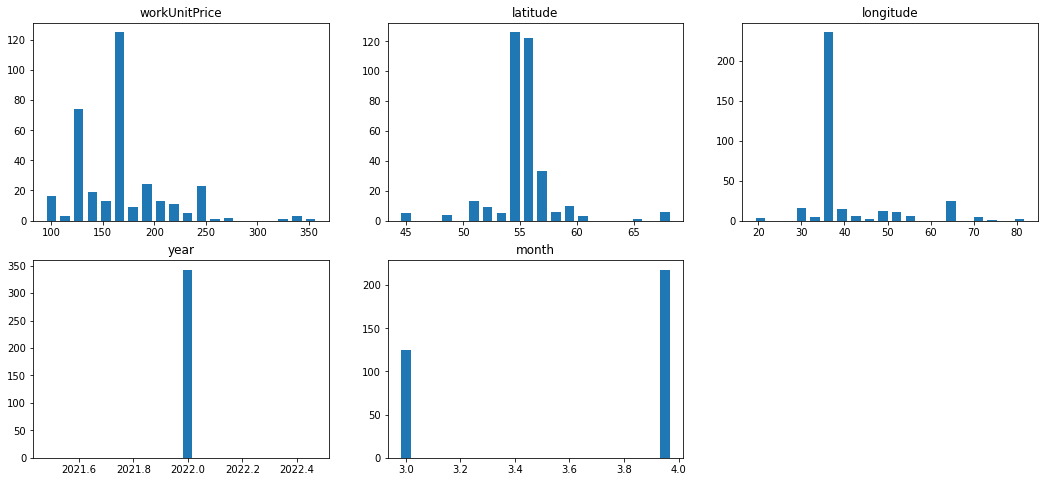

In [ ]:
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

visualize_distributions({
    'workUnitPrice': data_prod['workUnitPrice'].dropna(),
    'latitude': data_prod['latitude'].dropna(),
    'longitude': data_prod['longitude'].dropna(),
    'year': data_prod['year'].dropna(),
    'month': data_prod['month'].dropna()
})

In [ ]:
data_prod['lemmatized_description'] = data_prod['description'].swifter.apply(preprocess_text)
data_prod.head()

Pandas Apply:   0%|          | 0/343 [00:00<?, ?it/s]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,clientId,orderId,orderManagerId,objectId,priceListId,name,industry,...,mean_sal112021,mean_sal122021,mean_sal012022,mrot_2021,mrot_2022,pm_2021,pm_2022,year,month,lemmatized_description
0,0,0,5821,8aeee516-fe8b-41cc-8a84-1005982fd998,9f2fcf5e-5e71-49a9-9cbd-b55f9bb78718,59cffbdd-fb52-448d-8ce0-d0b33370a03c,6f4621aa-90a3-4088-804c-84aead1d1873,NaN,выкладка товара,NaN,...,64624.0,83117.0,64418.0,15000,16300,13580,14748,2022,4,выкладка товар
1,1,1,5845,e09cb55f-b62d-4acc-8647-6a65ec5ea937,794cb0f9-e49e-48c3-81d6-58abeff06df0,9faaf16f-7a4c-4c0c-ae36-a93086e735d9,e851dfce-f649-465f-8650-b7bc9544035a,NaN,Zenden. Мерчандайзинг.,NaN,...,37021.0,49391.0,38572.0,12792,13890,9938,11009,2022,4,проверка соответствие наличие ценник пополнени...
2,2,2,5882,ba5f2689-87df-483c-a115-942e1abf130a,9b507ef8-1a60-43dd-aeba-6b5b5e1a4cd6,c475ac8c-c7c5-4368-a4d4-dd11d0b11c88,6b2a2d79-6177-4234-9d50-f7c03b95c24c,NaN,Работник торгового зала,NaN,...,104877.0,172553.0,103124.0,20361,21371,18029,18714,2022,3,выкладка товар прилавок
3,3,3,5963,e09cb55f-b62d-4acc-8647-6a65ec5ea937,422db170-ced4-4991-a517-7102c58fa99a,f1056f8a-c08e-4fc6-992d-c5f22b9e5191,0670a2f7-531c-44da-ae97-b194266d1eed,NaN,Zenden. Мерчандайзинг.,NaN,...,42233.0,53047.0,40860.0,12792,14200,10015,11009,2022,4,проверка соответствие наличие ценник пополнени...
4,4,4,5964,c9597816-a374-41dc-be3e-b052b25c5582,bf7f0d13-1e44-43fc-9608-d9d6719853cb,9f66e9d8-3065-4af3-90bd-72d9a3809a04,44d948d4-6a65-482f-9ffa-bc0480e519e6,NaN,Zenden. Погрузо-разгрузочные работы.,NaN,...,75721.0,102627.0,75568.0,12792,13890,18625,20227,2022,4,осуществить погрузка разгрузка товар


In [ ]:
for speciality in top_words.keys():
    data_prod[speciality] = data_prod['lemmatized_description'].apply(count_words_from_top, args=(top_words[speciality],))

data_prod.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,clientId,orderId,orderManagerId,objectId,priceListId,name,industry,...,02aa72e5-25f4-4431-b9ae-c0e884b9eec3,b702d1bc-3bb8-4ef3-9cec-c5497bdd3c1b,7d225fcd-e2f4-4d4f-9b32-ccfe41d00338,2781a00b-692a-4e31-aee4-e38f40ba1204,0c0e3d17-3d22-458b-aad0-e6a578c091f8,fed91815-58de-49a1-ae0b-2f5deb32a6f3,643112d9-7adc-4017-87b4-f2c99c4c4ee4,2968c6b3-07f2-4f0c-b314-eabaf536d94d,2ce10ad8-3312-4c09-98ff-446824a9db8b,fbdb0f85-1254-4820-b656-09ec907d91ff
0,0,0,5821,8aeee516-fe8b-41cc-8a84-1005982fd998,9f2fcf5e-5e71-49a9-9cbd-b55f9bb78718,59cffbdd-fb52-448d-8ce0-d0b33370a03c,6f4621aa-90a3-4088-804c-84aead1d1873,NaN,выкладка товара,NaN,...,0,1,0,0,0,0,0,0,0,0
1,1,1,5845,e09cb55f-b62d-4acc-8647-6a65ec5ea937,794cb0f9-e49e-48c3-81d6-58abeff06df0,9faaf16f-7a4c-4c0c-ae36-a93086e735d9,e851dfce-f649-465f-8650-b7bc9544035a,NaN,Zenden. Мерчандайзинг.,NaN,...,0,0,0,0,2,0,2,0,0,0
2,2,2,5882,ba5f2689-87df-483c-a115-942e1abf130a,9b507ef8-1a60-43dd-aeba-6b5b5e1a4cd6,c475ac8c-c7c5-4368-a4d4-dd11d0b11c88,6b2a2d79-6177-4234-9d50-f7c03b95c24c,NaN,Работник торгового зала,NaN,...,0,1,0,0,0,0,0,0,0,0
3,3,3,5963,e09cb55f-b62d-4acc-8647-6a65ec5ea937,422db170-ced4-4991-a517-7102c58fa99a,f1056f8a-c08e-4fc6-992d-c5f22b9e5191,0670a2f7-531c-44da-ae97-b194266d1eed,NaN,Zenden. Мерчандайзинг.,NaN,...,0,0,0,0,2,0,2,0,0,0
4,4,4,5964,c9597816-a374-41dc-be3e-b052b25c5582,bf7f0d13-1e44-43fc-9608-d9d6719853cb,9f66e9d8-3065-4af3-90bd-72d9a3809a04,44d948d4-6a65-482f-9ffa-bc0480e519e6,NaN,Zenden. Погрузо-разгрузочные работы.,NaN,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_prod['mean_sal042021ho'] = (data_prod['mean_sal042021']/30/8).round(0)
data_prod['mean_sal052021ho'] = (data_prod['mean_sal052021']/30/8).round(0)
data_prod['mean_sal062021ho'] = (data_prod['mean_sal062021']/30/8).round(0)
data_prod['mean_sal072021ho'] = (data_prod['mean_sal072021']/30/8).round(0)
data_prod['mean_sal082021ho'] = (data_prod['mean_sal082021']/30/8).round(0)
data_prod['mean_sal092021ho'] = (data_prod['mean_sal092021']/30/8).round(0)
data_prod['mean_sal102021ho'] = (data_prod['mean_sal102021']/30/8).round(0)
data_prod['mean_sal112021ho'] = (data_prod['mean_sal112021']/30/8).round(0)
data_prod['mean_sal122021ho'] = (data_prod['mean_sal122021']/30/8).round(0)
data_prod['mean_sal012022ho'] = (data_prod['mean_sal012022']/30/8).round(0)
data_prod['mrot_2021ho'] = (data_prod['mrot_2021']/30/8).round(0)
data_prod['mrot_2022ho'] = (data_prod['mrot_2022']/30/8).round(0)

In [ ]:
columns1 = ['mean_sal042021ho', 'mean_sal052021ho', 'mean_sal062021ho', 'mean_sal072021ho', 'mean_sal082021ho', 'mean_sal092021ho', 'mean_sal102021ho', 'mean_sal112021ho', 'mean_sal122021ho', 'mean_sal012022ho']
columns2 = ['mrot_2021ho', 'mrot_2022ho', 'pm_2021', 'pm_2022']

In [ ]:
columns = list(df['specialityId'].unique())+['year', 'month', 'latitude', 'longitude']+columns1+columns2
X = data_prod[columns]
y = data_prod['workUnitPrice']

In [ ]:
y_pred = model.predict(X)
r2_score(y, y_pred)

0.7871194955926643

In [ ]:
mean_absolute_percentage_error(y, y_pred)

0.0599175954596944

In [ ]:
y_pred = cb.best_estimator_.predict(X)
r2_score(y, y_pred)

AttributeError: ignored

In [ ]:
mean_absolute_percentage_error(y, y_pred)

0.06344526311874817